In [2]:
from inference import get_model
import supervision as sv
import cv2
from tqdm import tqdm
import numpy as np


In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0))


**FOOTBALL PLAYER DETECTION**

In [ ]:
player_detection_model = get_model(model_id="football-players-detection-3zvbc-7sass/1", api_key="Your API Key")



In [3]:
import onnxruntime as ort
print(ort.get_available_providers())


['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [82]:
video_path = 'source\_08fd33_4.mp4'
target_video_path = 'player_detection_result.mp4'
device = 'cuda'

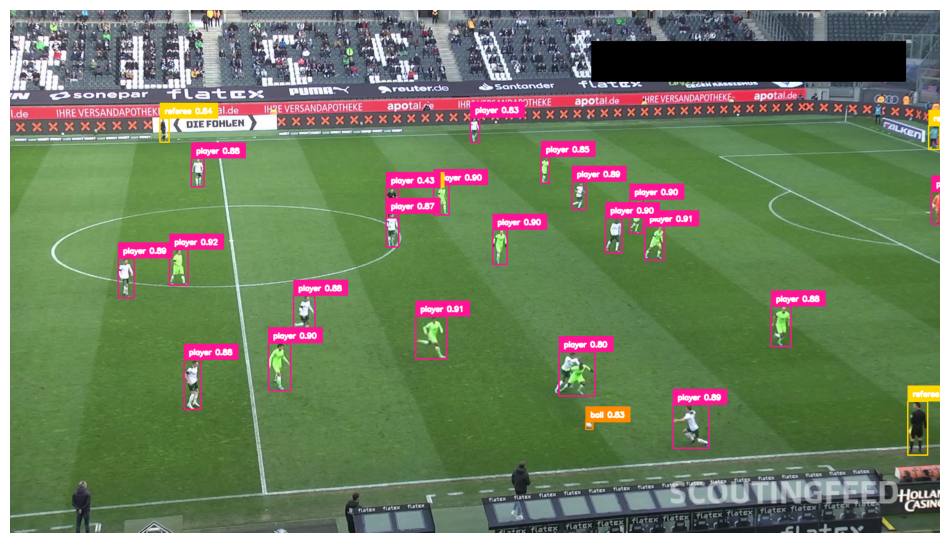

In [83]:
box_annator = sv.BoxAnnotator(
    color= sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', 'FFD700']),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color= sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', 'FFD700']),
    text_thickness=2
)

# video_info = sv.VideoInfo.from_video_path(video_path)
# video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)
frame = next(frame_generator)

# with video_sink:
#     for frame in tqdm(frame_generator, total=video_info.total_frames):
result = player_detection_model.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f'{class_name} {confidence:.2f}'
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence )
]

annotated_frame = frame.copy()
annotated_frame = box_annator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)
# video_sink.write_frame(annotated_frame)

sv.plot_image(annotated_frame)

In [ ]:
target_video_path = 'player_detection_result.mp4'

In [ ]:
BALL_ID = 0

import supervision as sv


triangle_annotator = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#FFE333')
)
ellipse_annotator = sv.EllipseAnnotator(
    color= sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', 'FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color= sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', 'FFD700']),
    text_thickness=2,
    text_position= sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(video_path)
video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)
# frame = next(frame_generator)


with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = player_detection_model.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id -1
        all_detections = tracker.update_with_detections(all_detections)

        labels = [
            f'# {tracker_id}'
            for tracker_id
            in all_detections.tracker_id 
        ]

        annotated_frame = frame.copy()
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections ,labels=labels)
        video_sink.write_frame(annotated_frame)

100%|██████████| 750/750 [20:51<00:00,  1.67s/it]


In [7]:
stride = 30
PLAYER_ID = 2

def extract_crops(video_path:str):
    frame_generator = sv.get_video_frames_generator(video_path, stride=stride)

    crops = []
    for frame in tqdm(frame_generator, desc='collecting_crops'):
        result = player_detection_model.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops +=[
            sv.crop_image(frame, xyxy)
            for xyxy
            in detections.xyxy
        ]
    return crops



In [8]:
crops = extract_crops(video_path)

collecting_crops: 25it [00:07,  3.25it/s]


In [9]:
len(crops)

505

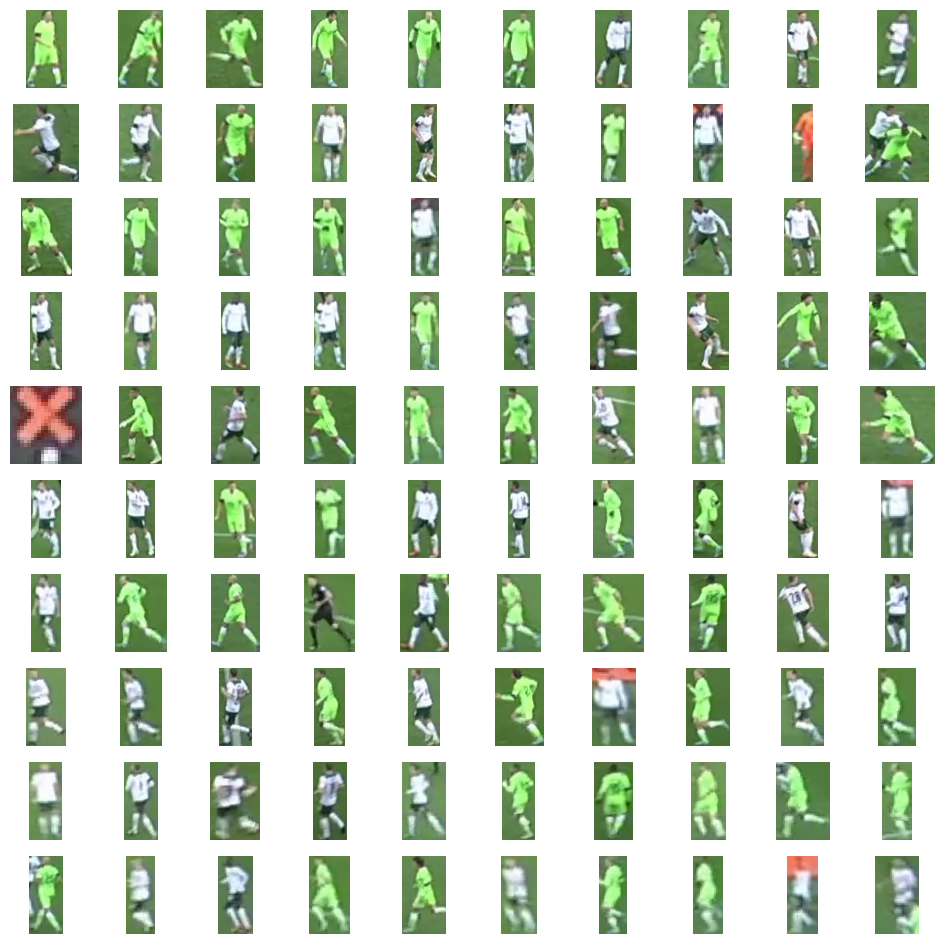

In [10]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [11]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

siglip_model_path = 'google/siglip-base-patch16-224'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_model = SiglipVisionModel.from_pretrained(siglip_model_path).to(device)
embedding_processor = AutoProcessor.from_pretrained(siglip_model_path)

In [12]:
from more_itertools import chunked 
batch_size = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, batch_size)
data = []

with torch.no_grad():
    for batch in tqdm(batches, desc='embeddings extraction'):
        inputs = embedding_processor(images=batch, return_tensors='pt').to(device)
        outputs = embedding_model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data) 



embeddings extraction: 16it [00:05,  2.70it/s]


In [13]:
data.shape

(505, 768)

In [21]:
import umap
from sklearn.cluster import KMeans

reducer = umap.UMAP(n_components=3)
clustering_model = KMeans(n_clusters=2)

In [22]:
project = reducer.fit_transform(data)

In [23]:
project.shape

(505, 3)

In [26]:
clusters = clustering_model.fit_predict(project)

In [27]:
clusters[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int32)

In [28]:
team_0 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster==0
]


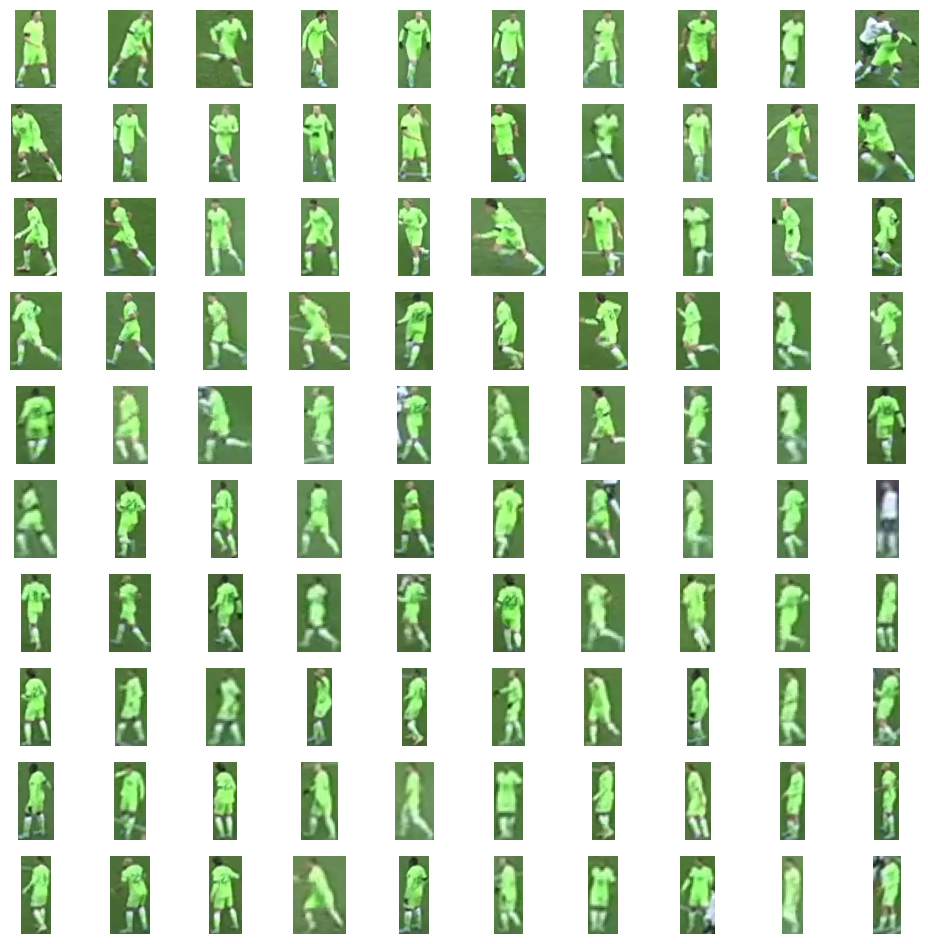

In [29]:
sv.plot_images_grid(team_0[:100], grid_size=[10,10])

collecting_crops: 25it [00:07,  3.35it/s]


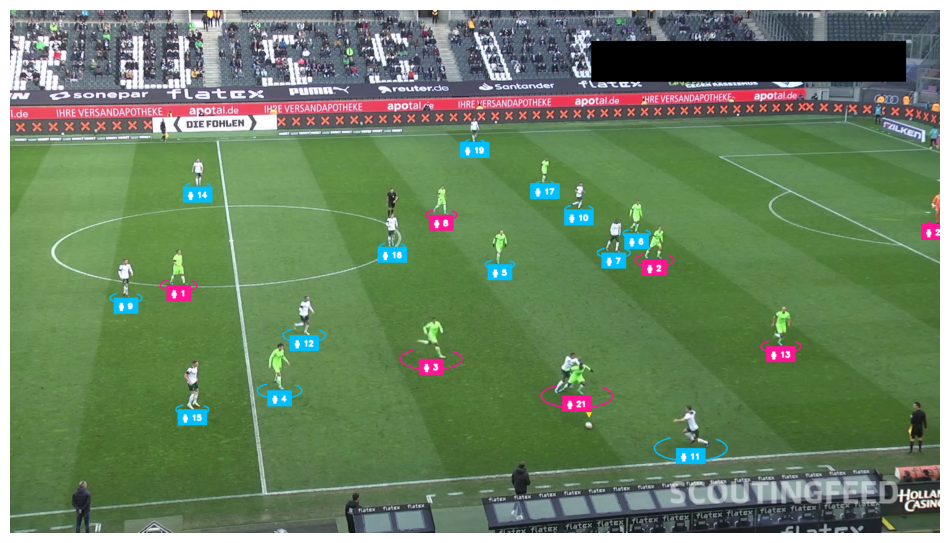

In [7]:
from transformers import SiglipProcessor, SiglipModel
import torch
import supervision as sv
import numpy as np

BALL_ID = 0
PLAYER_ID = 2

# Load SigLIP model and processor
siglip_model_id = "google/siglip-base-patch16-224"
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = SiglipProcessor.from_pretrained(siglip_model_id)
embedding_model = SiglipModel.from_pretrained(siglip_model_id).to(device)

def classify_team(crops):
    labels = [
        "a player from Manchester United",
        "a player from Chelsea",
        "a player from Barcelona"
    ]
    predictions = []
    with torch.no_grad():
        for crop in crops:
            image = sv.cv2_to_pillow(crop)
            inputs = processor(images=image, return_tensors="pt").to(device)
            image_emb = embedding_model.get_image_features(**inputs)

            text_inputs = processor(text=labels, return_tensors="pt", padding=True).to(device)
            text_emb = embedding_model.get_text_features(**text_inputs)

            similarity = torch.nn.functional.cosine_similarity(image_emb, text_emb)
            predicted = similarity.argmax().item()
            predictions.append(predicted)
    return predictions

# Extract player crops
crops = extract_crops(video_path)
team_predictions = classify_team(crops)

# Annotation tools
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFE333')
)
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', 'FFD700']), 
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', 'FFD700']), 
    text_thickness=2, 
    text_position=sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(video_path)
frame = next(frame_generator)

result = player_detection_model.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(all_detections)

player_detections = all_detections[all_detections.class_id == PLAYER_ID]

# Assign predicted team class IDs
player_detections.class_id = np.array(team_predictions)

# Labels for visualization
labels = [f"# {tracker_id}" for tracker_id in player_detections.tracker_id]

# Annotate frame
annotated_frame = frame.copy()
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
annotated_frame = ellipse_annotator.annotate(annotated_frame, player_detections)
annotated_frame = label_annotator.annotate(annotated_frame, player_detections, labels=labels)

# Show frame (Jupyter)
sv.plot_image(annotated_frame)


In [20]:
target_video_path = 'player_detection_result.mp4'

In [8]:
def resolve_goalkeeper_team_id(
    player_detections: sv.Detections,
    goalkeeper_detections: sv.Detections
):
    goalkeeper_xy = goalkeeper_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    player_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    team_0_centroid = player_xy[player_detections.class_id == 0].mean(axis=0)
    team_1_centroid = player_xy[player_detections.class_id == 1].mean(axis=0)

    goalkeeper_team_ids = []
    for goalkeeper_xy in goalkeeper_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeeper_team_ids.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeeper_team_ids)    

In [ ]:
from sports.common.team import TeamClassifier
import supervision as sv

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

crops = extract_crops(video_path)
team_classifier = TeamClassifier(device=device)
team_classifier.fit(crops)

triangle_annotator = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#FFE333')
)
ellipse_annotator = sv.EllipseAnnotator(
    color= sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', 'FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color= sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', 'FFD700']),
    text_thickness=2,
    text_position= sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(video_path)
video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)
# frame = next(frame_generator)


with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = player_detection_model.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(all_detections)

        player_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeeper_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referee_detections = all_detections[all_detections.class_id == REFEREE_ID]


        player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
        player_detections.class_id = team_classifier.predict(player_crops).astype(int)

        goalkeeper_detections.class_id = resolve_goalkeeper_team_id(
            player_detections,
            goalkeeper_detections
        ).astype(int)

        referee_detections.class_id -= 1

        all_detections = sv.Detections.merge([player_detections, goalkeeper_detections, referee_detections])

        labels = [
            f'# {tracker_id}'
            for tracker_id
            in all_detections.tracker_id 
        ]

        annotated_frame = frame.copy()
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections ,labels=labels)
        video_sink.write_frame(annotated_frame)

# sv.plot_image(annotated_frame)

collecting_crops: 25it [00:07,  3.30it/s]
Embedding extraction: 16it [00:05,  2.92it/s]
  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  5.79it/s]
  0%|          | 1/750 [00:00<06:25,  1.95it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.36it/s]
  0%|          | 2/750 [00:01<06:32,  1.90it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.58it/s]
  0%|          | 3/750 [00:01<06:31,  1.91it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.61it/s]
  1%|          | 4/750 [00:02<06:25,  1.94it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.77it/s]
  1%|          | 5/750 [00:02<06:19,  1.96it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  5.03it/s]
  1%|          | 6/750 [00:03<06:14,  1.99it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [

**FOOTBALL PITCH DETECTION**

In [ ]:
pitch_detection_model = get_model(model_id="football-field-detection-f07vi/15", api_key="Your API Key")

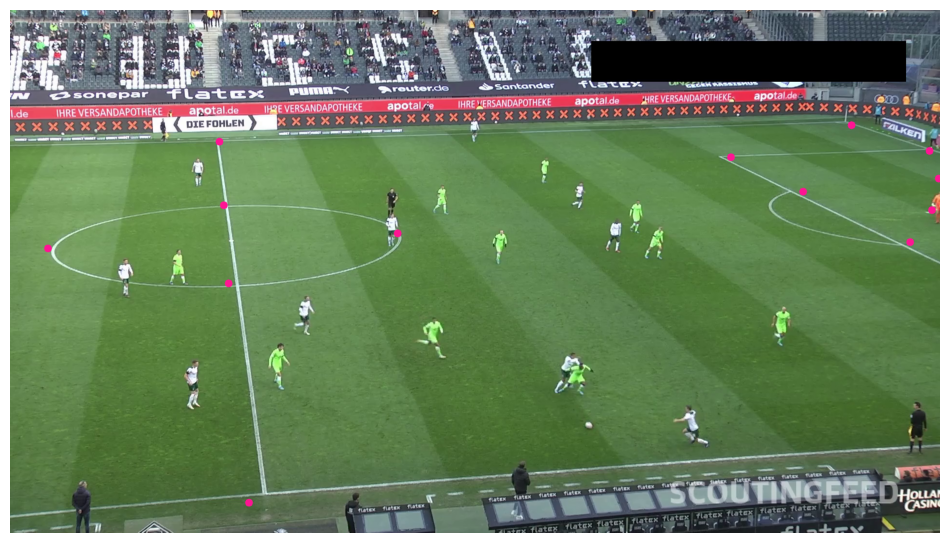

In [10]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

frame_generator = sv.get_video_frames_generator(video_path)
frame = next(frame_generator)

result = pitch_detection_model.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_point = key_points.xy[0][filter]
frame_reference_point = sv.KeyPoints(xy=frame_reference_point[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_point)

sv.plot_image(annotated_frame)

In [11]:
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch, draw_pitch_voronoi_diagram


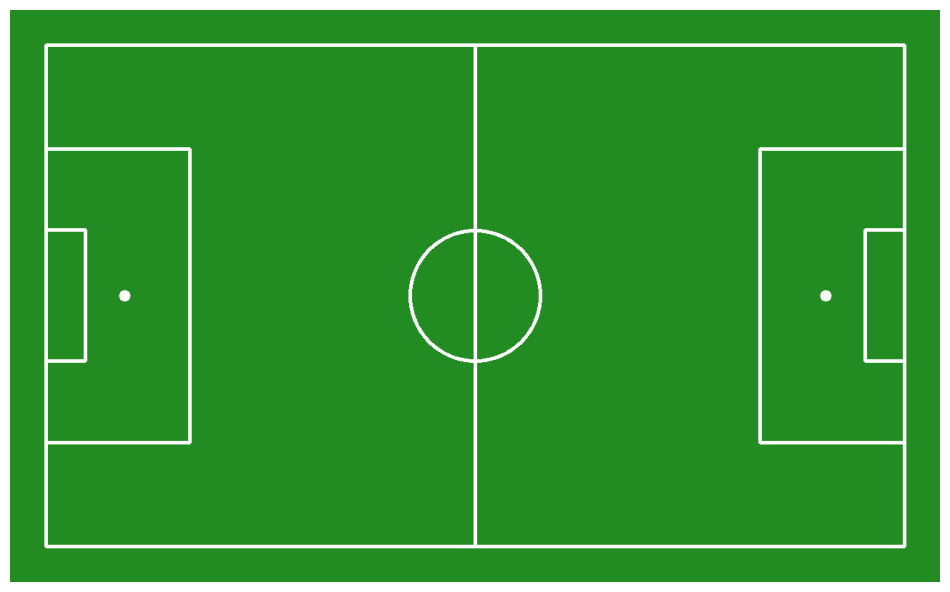

In [12]:
config = SoccerPitchConfiguration()
annotated_frame = draw_pitch(config)
sv.plot_image(annotated_frame)

In [13]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target)

    def transform_points(self, points: np.array):
        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)
        

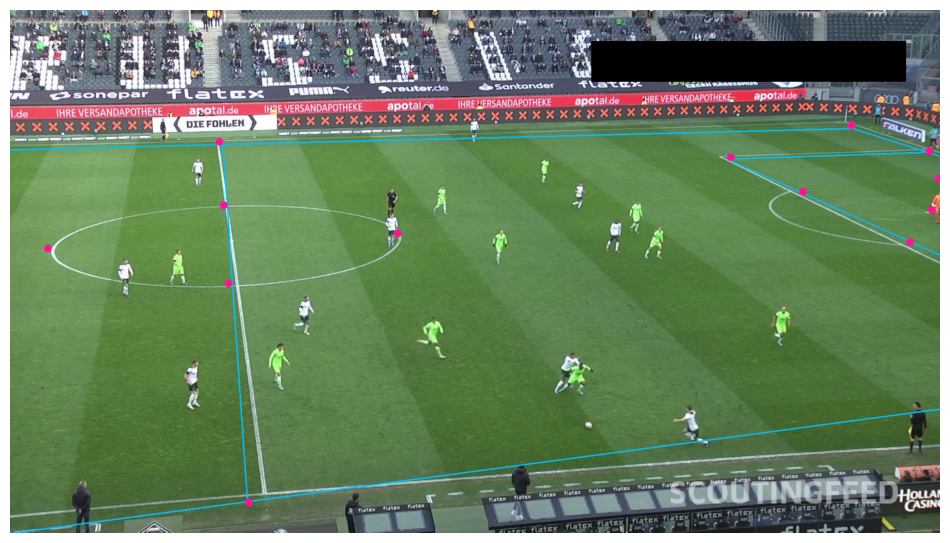

In [14]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('00BFFF'),
    thickness=2,
    edges=config.edges
)

frame_generator = sv.get_video_frames_generator(video_path)
frame = next(frame_generator)

result = pitch_detection_model.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_point = key_points.xy[0][filter]
frame_reference_key_point = sv.KeyPoints(xy=frame_reference_point[np.newaxis, ...])
pitch_reference_point = np.array(config.vertices)[filter]

view_transformer = ViewTransformer(
    source=pitch_reference_point,
    target=frame_reference_point
)

pitch_all_points = np.array(config.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_key_point)

sv.plot_image(annotated_frame)

In [15]:
target_video_path = 'pitch_detection_result.mp4'

In [17]:
from sports.common.team import TeamClassifier
import supervision as sv
from sports.common.view import ViewTransformer

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

crops = extract_crops(video_path)
team_classifier = TeamClassifier(device=device)
team_classifier.fit(crops)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(video_path)
video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)
# frame = next(frame_generator)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = player_detection_model.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(all_detections)

        player_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeeper_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referee_detections = all_detections[all_detections.class_id == REFEREE_ID]


        player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
        player_detections.class_id = team_classifier.predict(player_crops).astype(int)

        goalkeeper_detections.class_id = resolve_goalkeeper_team_id(
            player_detections,
            goalkeeper_detections
        ).astype(int)

        result = pitch_detection_model.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        filter = key_points.confidence[0] > 0.5
        frame_reference_point = key_points.xy[0][filter]
        frame_reference_key_point = sv.KeyPoints(xy=frame_reference_point[np.newaxis, ...])
        pitch_reference_point = np.array(config.vertices)[filter]

        view_transformer = ViewTransformer(
            source=frame_reference_point,
            target=pitch_reference_point
        )




        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)


        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

        frame_player_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_player_xy = view_transformer.transform_points(frame_player_xy)

        frame_referee_xy = referee_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referee_xy = view_transformer.transform_points(frame_referee_xy)


        pitch = draw_pitch(config)
        pitch = draw_points_on_pitch(
            config=config,
            xy = pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )
        pitch = draw_points_on_pitch(
            config=config,
            xy=pitch_player_xy[player_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch    
        )
        pitch = draw_points_on_pitch(
            config=config,
            xy=pitch_player_xy[player_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch    
        )
        pitch = draw_points_on_pitch(
            config=config,
            xy=pitch_referee_xy,
            face_color=sv.Color.from_hex('FFD700'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch    
        )
        # pitch = cv2.cvtColor(pitch, cv2.COLOR_RGB2BGR)
        pitch_resized = cv2.resize(pitch, (video_info.width, video_info.height))
        video_sink.write_frame(pitch_resized)


# sv.plot_image(pitch)
        




collecting_crops: 25it [00:07,  3.36it/s]
Embedding extraction: 16it [00:05,  2.86it/s]
  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.85it/s]
  0%|          | 1/750 [00:00<07:59,  1.56it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.69it/s]
  0%|          | 2/750 [00:01<07:38,  1.63it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.01it/s]
  0%|          | 3/750 [00:01<07:42,  1.62it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.53it/s]
  1%|          | 4/750 [00:02<07:29,  1.66it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.48it/s]
  1%|          | 5/750 [00:03<07:22,  1.69it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.58it/s]
  1%|          | 6/750 [00:03<07:19,  1.69it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [

**VORONOI DIAGRAM**

collecting_crops: 25it [00:07,  3.32it/s]
Embedding extraction: 16it [00:05,  2.91it/s]
Embedding extraction: 1it [00:00,  4.44it/s]


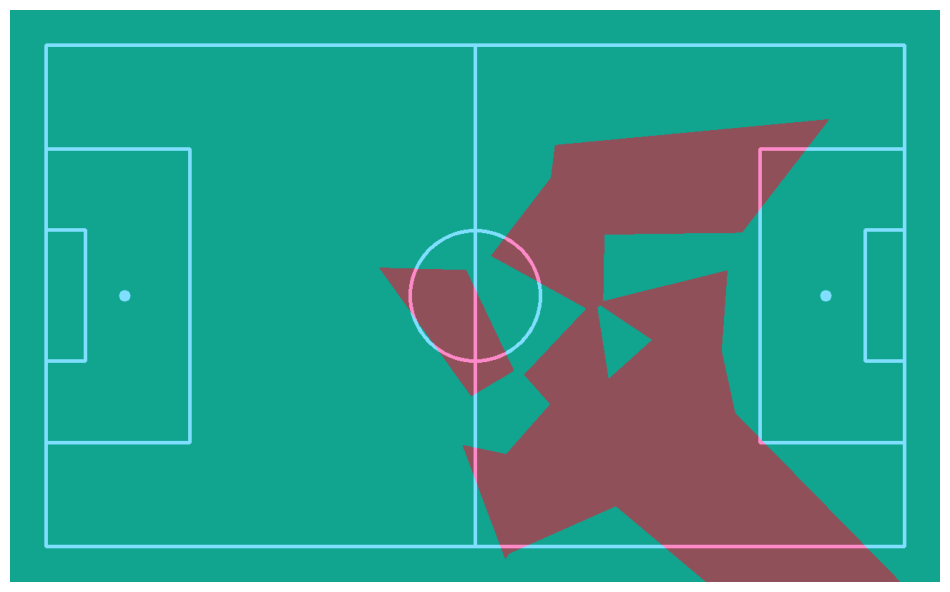

In [20]:
from sports.common.team import TeamClassifier
import supervision as sv
from sports.common.view import ViewTransformer

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

crops = extract_crops(video_path)
team_classifier = TeamClassifier(device=device)
team_classifier.fit(crops)

tracker = sv.ByteTrack()
tracker.reset()

# video_info = sv.VideoInfo.from_video_path(video_path)
# video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)
frame = next(frame_generator)

# with video_sink:
#     for frame in tqdm(frame_generator, total=video_info.total_frames):

result = player_detection_model.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(all_detections)

player_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeeper_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referee_detections = all_detections[all_detections.class_id == REFEREE_ID]


player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
player_detections.class_id = team_classifier.predict(player_crops).astype(int)

goalkeeper_detections.class_id = resolve_goalkeeper_team_id(
    player_detections,
    goalkeeper_detections
).astype(int)

result = pitch_detection_model.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_point = key_points.xy[0][filter]
frame_reference_key_point = sv.KeyPoints(xy=frame_reference_point[np.newaxis, ...])
pitch_reference_point = np.array(config.vertices)[filter]

view_transformer = ViewTransformer(
    source=frame_reference_point,
    target=pitch_reference_point
)




frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)


frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

frame_player_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_player_xy = view_transformer.transform_points(frame_player_xy)

frame_referee_xy = referee_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referee_xy = view_transformer.transform_points(frame_referee_xy)


pitch = draw_pitch(config)
pitch = draw_pitch_voronoi_diagram(
    config,
    team_1_xy=pitch_player_xy[player_detections.class_id == 0],
    team_2_xy=pitch_player_xy[player_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),    
)

sv.plot_image(pitch)
# pitch_resized = cv2.resize(pitch, (video_info.width, video_info.height))
# video_sink.write_frame(pitch_resized)


In [46]:
from sports.common.team import TeamClassifier
import supervision as sv
from sports.common.view import ViewTransformer

target_video_path = 'voronoi_diagram_result.mp4'

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

crops = extract_crops(video_path)
team_classifier = TeamClassifier(device=device)
team_classifier.fit(crops)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(video_path)
video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)
# frame = next(frame_generator)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = player_detection_model.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(all_detections)

        player_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeeper_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referee_detections = all_detections[all_detections.class_id == REFEREE_ID]


        player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
        player_detections.class_id = team_classifier.predict(player_crops).astype(int)

        goalkeeper_detections.class_id = resolve_goalkeeper_team_id(
            player_detections,
            goalkeeper_detections
        ).astype(int)

        result = pitch_detection_model.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        filter = key_points.confidence[0] > 0.5
        frame_reference_point = key_points.xy[0][filter]
        frame_reference_key_point = sv.KeyPoints(xy=frame_reference_point[np.newaxis, ...])
        pitch_reference_point = np.array(config.vertices)[filter]

        view_transformer = ViewTransformer(
            source=frame_reference_point,
            target=pitch_reference_point
        )




        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)


        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

        frame_player_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_player_xy = view_transformer.transform_points(frame_player_xy)

        frame_referee_xy = referee_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referee_xy = view_transformer.transform_points(frame_referee_xy)


        pitch = draw_pitch(config)
        pitch = draw_pitch_voronoi_diagram(
            config,
            team_1_xy=pitch_player_xy[player_detections.class_id == 0],
            team_2_xy=pitch_player_xy[player_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),    
        )


        pitch_resized = cv2.resize(pitch, (video_info.width, video_info.height))
        video_sink.write_frame(pitch_resized)


collecting_crops: 25it [00:07,  3.29it/s]
Embedding extraction: 16it [00:05,  2.82it/s]
  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.30it/s]
  0%|          | 1/750 [00:01<12:33,  1.01s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  5.00it/s]
  0%|          | 2/750 [00:01<11:54,  1.05it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.49it/s]
  0%|          | 3/750 [00:02<11:35,  1.07it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.27it/s]
  1%|          | 4/750 [00:03<11:35,  1.07it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.32it/s]
  1%|          | 5/750 [00:04<11:28,  1.08it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.36it/s]
  1%|          | 6/750 [00:05<11:23,  1.09it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [

**BALL TERRITORY**

In [20]:
import supervision as sv
from sports.common.view import ViewTransformer
from collections import deque

BALL_ID = 0
MAXLEN = 5

path_raw = []
M = deque(maxlen=MAXLEN)


tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(video_path)
video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)

for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = player_detection_model.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = pitch_detection_model.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_point = key_points.xy[0][filter]
    pitch_reference_point = np.array(config.vertices)[filter]

    view_transformer = ViewTransformer(
        source=frame_reference_point,
        target=pitch_reference_point
    )

    M.append(view_transformer.m)
    view_transformer.m = np.mean(np.array(M), axis=0)



    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)


    path_raw.append(pitch_ball_xy)




100%|██████████| 750/750 [03:57<00:00,  3.16it/s]


In [21]:
path_raw

[array([[     7266.1,      6745.7]], dtype=float32),
 array([[     7267.5,      6744.3]], dtype=float32),
 array([[       7271,      6768.9]], dtype=float32),
 array([[       7276,      6789.7]], dtype=float32),
 array([], shape=(0, 2), dtype=float64),
 array([[     7280.9,      6837.9]], dtype=float32),
 array([[       7282,      6857.8]], dtype=float32),
 array([[     7283.2,      6881.4]], dtype=float32),
 array([[     7285.5,      6899.8]], dtype=float32),
 array([], shape=(0, 2), dtype=float64),
 array([[     7285.8,        6935]], dtype=float32),
 array([[     7286.7,      6956.8]], dtype=float32),
 array([[     7289.9,      6970.8]], dtype=float32),
 array([[     7288.5,      6987.7]], dtype=float32),
 array([[     7291.3,      7005.8]], dtype=float32),
 array([[     7290.1,      7023.4]], dtype=float32),
 array([[     7269.2,      7013.8]], dtype=float32),
 array([[     7243.4,      6998.8]], dtype=float32),
 array([[     7218.6,      6979.5]], dtype=float32),
 array([[     719

In [24]:
#clear when detecting >= 2 balls
path =[
    np.empty((0,2), dtype=np.float32) if coordinates.shape[0] >= 2 else coordinates
    for coordinates in path_raw
]

path = [coordinates.flatten() for coordinates in path]

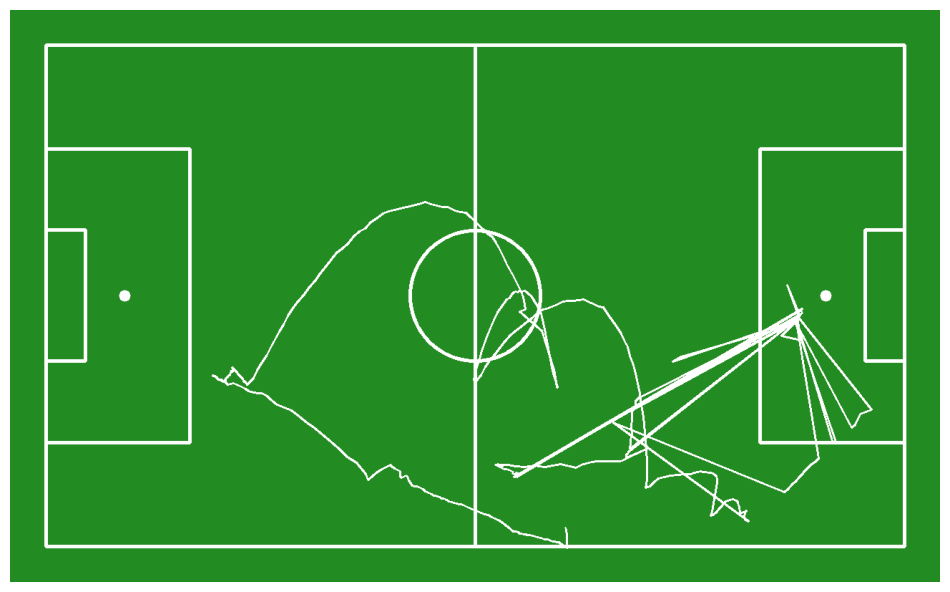

In [25]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(config)
annotated_frame = draw_paths_on_pitch(
    config,
    paths = [path],
    color = sv.Color.WHITE,
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

In [15]:
from typing import List, Union

def replace_outliers_based_on_distance(positions: List[np.ndarray], distance_threshold:float):
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position
    return cleaned_positions
                        




In [27]:
max_distance_threshold = 500
path = replace_outliers_based_on_distance(path, distance_threshold=max_distance_threshold) 

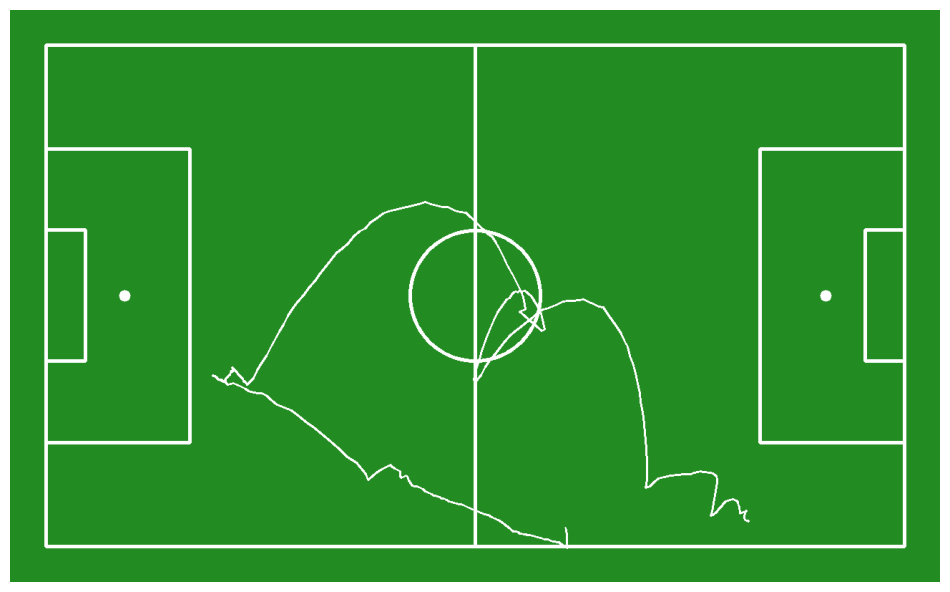

In [28]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(config)
annotated_frame = draw_paths_on_pitch(
    config,
    paths = [path],
    color = sv.Color.WHITE,
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

In [77]:
def replace_outliers_based_on_distance(positions: np.ndarray, distance_threshold: float) -> np.ndarray:
    last_valid_position = None
    cleaned_positions = []

    for position in positions:
        if position.size == 0:
            # Skip empty arrays by not adding them
            continue
        if last_valid_position is None:
            cleaned_positions.append(position)
            last_valid_position = position
        else:
            distance = np.linalg.norm(position - last_valid_position)
            if distance > distance_threshold:
                # Append None or skip
                # Skip adding
                continue
            else:
                cleaned_positions.append(position)
                last_valid_position = position

    if cleaned_positions:
        return np.stack(cleaned_positions)
    else:
        return np.empty((0, 2), dtype=np.float32)



In [ ]:
target_video_path = 'ball_territory_result.mp4'

In [79]:
from sports.common.view import ViewTransformer
from sports.annotators.soccer import draw_paths_on_pitch
from collections import deque

BALL_ID = 0
MAXLEN = 5

path_raw = []
M = deque(maxlen=MAXLEN)


tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(video_path)
video_sink = sv.VideoSink(target_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(video_path)

with video_sink:
    for frame_idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames)):
        if frame_idx == 250:
            print("Skipping known problematic frame 250")
            continue
        result = player_detection_model.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        result = pitch_detection_model.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        filter = key_points.confidence[0] > 0.5
        frame_reference_point = key_points.xy[0][filter]
        pitch_reference_point = np.array(config.vertices)[filter]

        view_transformer = ViewTransformer(
            source=frame_reference_point,
            target=pitch_reference_point
        )

        M.append(view_transformer.m)
        view_transformer.m = np.mean(np.array(M), axis=0)



        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

        # Append clean (2,) data
        if pitch_ball_xy.shape == (1, 2):
            coord = pitch_ball_xy[0]
            if isinstance(coord, np.ndarray) and coord.shape == (2,):
                path_raw.append(coord)


        valid_path = []
        for i, coord in enumerate(path_raw):
            try:
                coord = np.asarray(coord, dtype=np.float32)
                if coord.shape == (2,):
                    valid_path.append(coord)
                else:
                    print(f"[Frame {frame_idx}] Invalid shape at index {i}: {coord.shape}")
            except Exception as e:
                print(f"[Frame {frame_idx}] Skipping invalid coord at index {i} due to error: {e}")

        try:
            path = np.stack(valid_path)
        except ValueError as e:
            print(f"[Frame {frame_idx}] ERROR in np.stack: {e}")
            path = np.empty((0, 2), dtype=np.float32)  # fallback to empty path


        max_distance_threshold = 500
        path = replace_outliers_based_on_distance(path, distance_threshold=max_distance_threshold)
        



        annotated_frame = draw_pitch(config)
        print("After draw_pitch:", type(annotated_frame), 
            "None?" if annotated_frame is None else f"shape: {annotated_frame.shape}")

        if path.shape[0] > 0:
            annotated_frame = draw_paths_on_pitch(
                config,
                paths=[path],
                color=sv.Color.WHITE,
                pitch=annotated_frame
            )
            print("After draw_paths_on_pitch:", type(annotated_frame), 
                "None?" if annotated_frame is None else f"shape: {annotated_frame.shape}")
        else:
            print("No valid path points to draw")

        # Resize if annotated_frame is not None
        if annotated_frame is not None:
            pitch_resized = cv2.resize(annotated_frame, (video_info.width, video_info.height))
            video_sink.write_frame(pitch_resized)
        else:
            print("annotated_frame is None, skipping resizing and writing frame")

  0%|          | 0/750 [00:00<?, ?it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'NoneType'> None?
annotated_frame is None, skipping resizing and writing frame


  0%|          | 1/750 [00:00<08:07,  1.54it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  0%|          | 2/750 [00:01<06:01,  2.07it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  0%|          | 3/750 [00:01<05:14,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|          | 4/750 [00:01<04:55,  2.52it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|          | 5/750 [00:02<04:41,  2.65it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|          | 6/750 [00:02<04:32,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|          | 7/750 [00:02<04:25,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|          | 8/750 [00:03<04:26,  2.78it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|          | 9/750 [00:03<04:28,  2.76it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|▏         | 10/750 [00:03<04:28,  2.76it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  1%|▏         | 11/750 [00:04<04:26,  2.77it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  2%|▏         | 12/750 [00:04<04:22,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  2%|▏         | 13/750 [00:04<04:21,  2.82it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  2%|▏         | 14/750 [00:05<04:21,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  2%|▏         | 15/750 [00:05<04:20,  2.82it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  2%|▏         | 16/750 [00:05<04:23,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  2%|▏         | 17/750 [00:06<04:22,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  2%|▏         | 18/750 [00:06<04:25,  2.76it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 19/750 [00:07<05:02,  2.41it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 20/750 [00:07<05:19,  2.28it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 21/750 [00:08<05:22,  2.26it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 22/750 [00:08<05:29,  2.21it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 23/750 [00:09<05:32,  2.19it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 24/750 [00:09<05:37,  2.15it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 25/750 [00:10<05:27,  2.22it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  3%|▎         | 26/750 [00:10<05:01,  2.40it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  4%|▎         | 27/750 [00:10<04:46,  2.52it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  4%|▎         | 28/750 [00:11<04:37,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  4%|▍         | 29/750 [00:11<04:27,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  4%|▍         | 30/750 [00:11<04:20,  2.76it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  4%|▍         | 31/750 [00:12<04:15,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  4%|▍         | 32/750 [00:12<04:12,  2.84it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  4%|▍         | 33/750 [00:12<04:09,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▍         | 34/750 [00:13<04:06,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▍         | 35/750 [00:13<04:01,  2.97it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▍         | 36/750 [00:13<04:01,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▍         | 37/750 [00:14<04:00,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▌         | 38/750 [00:14<04:02,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▌         | 39/750 [00:14<04:00,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▌         | 40/750 [00:15<03:58,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  5%|▌         | 41/750 [00:15<03:59,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  6%|▌         | 42/750 [00:15<03:58,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  6%|▌         | 43/750 [00:16<03:57,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  6%|▌         | 44/750 [00:16<04:01,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  6%|▌         | 45/750 [00:16<03:59,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  6%|▌         | 46/750 [00:17<03:58,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  6%|▋         | 47/750 [00:17<03:58,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  6%|▋         | 48/750 [00:17<03:59,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 49/750 [00:18<03:57,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 50/750 [00:18<03:58,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 51/750 [00:18<03:56,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 52/750 [00:19<03:52,  3.00it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 53/750 [00:19<03:53,  2.99it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 54/750 [00:19<03:56,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 55/750 [00:20<04:03,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  7%|▋         | 56/750 [00:20<04:09,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  8%|▊         | 57/750 [00:20<04:10,  2.77it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  8%|▊         | 58/750 [00:21<04:10,  2.76it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  8%|▊         | 59/750 [00:21<04:11,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  8%|▊         | 60/750 [00:22<04:12,  2.74it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  8%|▊         | 61/750 [00:22<04:11,  2.74it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  8%|▊         | 62/750 [00:22<04:15,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  8%|▊         | 63/750 [00:23<04:14,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▊         | 64/750 [00:23<04:15,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▊         | 65/750 [00:23<04:16,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▉         | 66/750 [00:24<04:15,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▉         | 67/750 [00:24<04:15,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▉         | 68/750 [00:25<04:15,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▉         | 69/750 [00:25<04:14,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▉         | 70/750 [00:25<04:14,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


  9%|▉         | 71/750 [00:26<04:14,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 10%|▉         | 72/750 [00:26<04:11,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 10%|▉         | 73/750 [00:26<04:08,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 10%|▉         | 74/750 [00:27<04:09,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 10%|█         | 75/750 [00:27<04:09,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 10%|█         | 76/750 [00:28<04:05,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 10%|█         | 77/750 [00:28<04:01,  2.78it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 10%|█         | 78/750 [00:28<03:58,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█         | 79/750 [00:29<03:57,  2.83it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█         | 80/750 [00:29<03:57,  2.83it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█         | 81/750 [00:29<03:55,  2.84it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█         | 82/750 [00:30<03:55,  2.84it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█         | 83/750 [00:30<03:54,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█         | 84/750 [00:30<03:52,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█▏        | 85/750 [00:31<03:52,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 11%|█▏        | 86/750 [00:31<03:52,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 12%|█▏        | 87/750 [00:31<03:50,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 12%|█▏        | 88/750 [00:32<03:52,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 12%|█▏        | 89/750 [00:32<03:52,  2.84it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 12%|█▏        | 90/750 [00:32<03:50,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 12%|█▏        | 91/750 [00:33<03:49,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 12%|█▏        | 92/750 [00:33<03:50,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 12%|█▏        | 93/750 [00:33<03:50,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 94/750 [00:34<03:49,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 95/750 [00:34<03:47,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 96/750 [00:35<03:47,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 97/750 [00:35<03:45,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 98/750 [00:35<03:45,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 99/750 [00:36<03:44,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 100/750 [00:36<03:42,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 13%|█▎        | 101/750 [00:36<03:41,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 14%|█▎        | 102/750 [00:37<03:41,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 14%|█▎        | 103/750 [00:37<03:41,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 14%|█▍        | 104/750 [00:37<03:42,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 14%|█▍        | 105/750 [00:38<03:41,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 14%|█▍        | 106/750 [00:38<03:40,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 14%|█▍        | 107/750 [00:38<03:40,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 14%|█▍        | 108/750 [00:39<03:39,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▍        | 109/750 [00:39<03:38,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▍        | 110/750 [00:39<03:37,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▍        | 111/750 [00:40<03:39,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▍        | 112/750 [00:40<03:37,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▌        | 113/750 [00:40<03:39,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▌        | 114/750 [00:41<03:38,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▌        | 115/750 [00:41<03:37,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 15%|█▌        | 116/750 [00:41<03:37,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 16%|█▌        | 117/750 [00:42<03:36,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 16%|█▌        | 118/750 [00:42<03:34,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 16%|█▌        | 119/750 [00:42<03:37,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 16%|█▌        | 120/750 [00:43<03:36,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 16%|█▌        | 121/750 [00:43<03:36,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 16%|█▋        | 122/750 [00:43<03:37,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 16%|█▋        | 123/750 [00:44<03:35,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 124/750 [00:44<03:34,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 125/750 [00:44<03:36,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 126/750 [00:45<03:35,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 127/750 [00:45<03:31,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 128/750 [00:45<03:33,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 129/750 [00:46<03:33,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 130/750 [00:46<03:33,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 17%|█▋        | 131/750 [00:47<03:33,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 18%|█▊        | 132/750 [00:47<03:32,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 18%|█▊        | 133/750 [00:47<03:32,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 18%|█▊        | 134/750 [00:48<03:31,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 18%|█▊        | 135/750 [00:48<03:27,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 18%|█▊        | 136/750 [00:48<03:26,  2.97it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 18%|█▊        | 137/750 [00:49<03:25,  2.99it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 18%|█▊        | 138/750 [00:49<03:23,  3.01it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▊        | 139/750 [00:49<03:20,  3.05it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▊        | 140/750 [00:50<03:21,  3.03it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▉        | 141/750 [00:50<03:21,  3.02it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▉        | 142/750 [00:50<03:20,  3.03it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▉        | 143/750 [00:51<03:19,  3.04it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▉        | 144/750 [00:51<03:21,  3.01it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▉        | 145/750 [00:51<03:23,  2.97it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 19%|█▉        | 146/750 [00:52<03:25,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 20%|█▉        | 147/750 [00:52<03:24,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 20%|█▉        | 148/750 [00:52<03:22,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 20%|█▉        | 149/750 [00:53<03:22,  2.97it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 20%|██        | 150/750 [00:53<03:19,  3.00it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 20%|██        | 151/750 [00:53<03:19,  3.00it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 20%|██        | 152/750 [00:54<03:17,  3.03it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 20%|██        | 153/750 [00:54<03:17,  3.03it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██        | 154/750 [00:54<03:16,  3.03it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██        | 155/750 [00:55<03:19,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██        | 156/750 [00:55<03:20,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██        | 157/750 [00:55<03:21,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██        | 158/750 [00:56<03:22,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██        | 159/750 [00:56<03:22,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██▏       | 160/750 [00:56<03:23,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 21%|██▏       | 161/750 [00:57<03:24,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 22%|██▏       | 162/750 [00:57<03:24,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 22%|██▏       | 163/750 [00:57<03:23,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 22%|██▏       | 164/750 [00:58<03:27,  2.83it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 22%|██▏       | 165/750 [00:58<03:25,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 22%|██▏       | 166/750 [00:58<03:24,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 22%|██▏       | 167/750 [00:59<03:24,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 22%|██▏       | 168/750 [00:59<03:23,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 169/750 [00:59<03:22,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 170/750 [01:00<03:22,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 171/750 [01:00<03:20,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 172/750 [01:00<03:21,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 173/750 [01:01<03:18,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 174/750 [01:01<03:15,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 175/750 [01:01<03:13,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 23%|██▎       | 176/750 [01:02<03:10,  3.01it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 24%|██▎       | 177/750 [01:02<03:08,  3.03it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 24%|██▎       | 178/750 [01:02<03:09,  3.02it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 24%|██▍       | 179/750 [01:03<03:09,  3.01it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 24%|██▍       | 180/750 [01:03<03:11,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 24%|██▍       | 181/750 [01:03<03:11,  2.97it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 24%|██▍       | 182/750 [01:04<03:11,  2.97it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 24%|██▍       | 183/750 [01:04<03:13,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▍       | 184/750 [01:04<03:12,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▍       | 185/750 [01:05<03:12,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▍       | 186/750 [01:05<03:16,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▍       | 187/750 [01:06<03:15,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▌       | 188/750 [01:06<03:14,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▌       | 189/750 [01:06<03:12,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▌       | 190/750 [01:07<03:11,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 25%|██▌       | 191/750 [01:07<03:14,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 26%|██▌       | 192/750 [01:07<03:15,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 26%|██▌       | 193/750 [01:08<03:15,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 26%|██▌       | 194/750 [01:08<03:17,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 26%|██▌       | 195/750 [01:08<03:15,  2.84it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 26%|██▌       | 196/750 [01:09<03:13,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 26%|██▋       | 197/750 [01:09<03:13,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 26%|██▋       | 198/750 [01:09<03:13,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 199/750 [01:10<03:14,  2.84it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 200/750 [01:10<03:32,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 201/750 [01:11<03:33,  2.57it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 202/750 [01:11<03:34,  2.55it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 203/750 [01:11<03:30,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 204/750 [01:12<03:22,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 205/750 [01:12<03:18,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 27%|██▋       | 206/750 [01:12<03:15,  2.78it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 28%|██▊       | 207/750 [01:13<03:16,  2.76it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 28%|██▊       | 208/750 [01:13<03:14,  2.78it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 28%|██▊       | 209/750 [01:13<03:11,  2.82it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 28%|██▊       | 210/750 [01:14<03:08,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 28%|██▊       | 211/750 [01:14<03:11,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 28%|██▊       | 212/750 [01:15<03:10,  2.83it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 28%|██▊       | 213/750 [01:15<03:09,  2.83it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▊       | 214/750 [01:15<03:05,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▊       | 215/750 [01:16<03:10,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▉       | 216/750 [01:16<03:13,  2.76it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▉       | 217/750 [01:16<03:08,  2.83it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▉       | 218/750 [01:17<03:10,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▉       | 219/750 [01:17<03:13,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▉       | 220/750 [01:17<03:08,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 29%|██▉       | 221/750 [01:18<03:10,  2.78it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 30%|██▉       | 222/750 [01:18<03:08,  2.80it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 30%|██▉       | 223/750 [01:18<03:07,  2.82it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 30%|██▉       | 224/750 [01:19<03:05,  2.84it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 30%|███       | 225/750 [01:19<03:02,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 30%|███       | 226/750 [01:19<03:01,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 30%|███       | 227/750 [01:20<03:04,  2.83it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 30%|███       | 228/750 [01:20<03:08,  2.77it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███       | 229/750 [01:21<03:02,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███       | 230/750 [01:21<03:01,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███       | 231/750 [01:21<02:59,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███       | 232/750 [01:22<02:58,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███       | 233/750 [01:22<02:59,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███       | 234/750 [01:22<02:57,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███▏      | 235/750 [01:23<03:00,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 31%|███▏      | 236/750 [01:23<03:00,  2.85it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 32%|███▏      | 237/750 [01:23<02:59,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 32%|███▏      | 238/750 [01:24<02:56,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 32%|███▏      | 239/750 [01:24<03:02,  2.80it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 32%|███▏      | 240/750 [01:24<03:01,  2.82it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 32%|███▏      | 241/750 [01:25<03:02,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 32%|███▏      | 242/750 [01:25<03:03,  2.77it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 32%|███▏      | 243/750 [01:25<03:04,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 33%|███▎      | 244/750 [01:26<03:05,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 33%|███▎      | 245/750 [01:26<03:01,  2.78it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 33%|███▎      | 246/750 [01:27<03:04,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 33%|███▎      | 247/750 [01:27<03:05,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 33%|███▎      | 248/750 [01:27<03:06,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 33%|███▎      | 249/750 [01:28<03:03,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 33%|███▎      | 250/750 [01:28<03:05,  2.70it/s]

Skipping known problematic frame 250
After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 34%|███▎      | 252/750 [01:28<02:22,  3.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 34%|███▎      | 253/750 [01:29<02:32,  3.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 34%|███▍      | 254/750 [01:29<02:39,  3.10it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 34%|███▍      | 255/750 [01:30<02:45,  2.99it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 34%|███▍      | 256/750 [01:30<02:47,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 34%|███▍      | 257/750 [01:30<02:48,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 34%|███▍      | 258/750 [01:31<02:47,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▍      | 259/750 [01:31<02:46,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▍      | 260/750 [01:31<02:45,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▍      | 261/750 [01:32<02:48,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▍      | 262/750 [01:32<02:47,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▌      | 263/750 [01:32<02:46,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▌      | 264/750 [01:33<02:47,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▌      | 265/750 [01:33<02:47,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 35%|███▌      | 266/750 [01:33<02:47,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 36%|███▌      | 267/750 [01:34<02:47,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 36%|███▌      | 268/750 [01:34<02:47,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 36%|███▌      | 269/750 [01:34<02:46,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 36%|███▌      | 270/750 [01:35<02:45,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 36%|███▌      | 271/750 [01:35<02:46,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 36%|███▋      | 272/750 [01:35<02:46,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 36%|███▋      | 273/750 [01:36<02:44,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 274/750 [01:36<02:44,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 275/750 [01:36<02:43,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 276/750 [01:37<02:43,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 277/750 [01:37<02:44,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 278/750 [01:37<02:41,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 279/750 [01:38<02:43,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 280/750 [01:38<02:42,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 37%|███▋      | 281/750 [01:39<02:40,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 38%|███▊      | 282/750 [01:39<02:39,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 38%|███▊      | 283/750 [01:39<02:39,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 38%|███▊      | 284/750 [01:40<02:38,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 38%|███▊      | 285/750 [01:40<02:41,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 38%|███▊      | 286/750 [01:40<02:40,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 38%|███▊      | 287/750 [01:41<02:40,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 38%|███▊      | 288/750 [01:41<02:40,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▊      | 289/750 [01:41<02:39,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▊      | 290/750 [01:42<02:37,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▉      | 291/750 [01:42<02:36,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▉      | 292/750 [01:42<02:36,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▉      | 293/750 [01:43<02:35,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▉      | 294/750 [01:43<02:35,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▉      | 295/750 [01:43<02:34,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 39%|███▉      | 296/750 [01:44<02:34,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 40%|███▉      | 297/750 [01:44<02:34,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 40%|███▉      | 298/750 [01:44<02:34,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 40%|███▉      | 299/750 [01:45<02:33,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 40%|████      | 300/750 [01:45<02:33,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 40%|████      | 301/750 [01:45<02:34,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 40%|████      | 302/750 [01:46<02:33,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 40%|████      | 303/750 [01:46<02:34,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████      | 304/750 [01:46<02:34,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████      | 305/750 [01:47<02:34,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████      | 306/750 [01:47<02:34,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████      | 307/750 [01:47<02:33,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████      | 308/750 [01:48<02:33,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████      | 309/750 [01:48<02:32,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████▏     | 310/750 [01:48<02:31,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 41%|████▏     | 311/750 [01:49<02:31,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 42%|████▏     | 312/750 [01:49<02:30,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 42%|████▏     | 313/750 [01:50<02:28,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 42%|████▏     | 314/750 [01:50<02:26,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 42%|████▏     | 315/750 [01:50<02:24,  3.01it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 42%|████▏     | 316/750 [01:51<02:25,  2.99it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 42%|████▏     | 317/750 [01:51<02:26,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 42%|████▏     | 318/750 [01:51<02:28,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 319/750 [01:52<02:27,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 320/750 [01:52<02:26,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 321/750 [01:52<02:27,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 322/750 [01:53<02:27,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 323/750 [01:53<02:26,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 324/750 [01:53<02:26,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 325/750 [01:54<02:25,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 43%|████▎     | 326/750 [01:54<02:26,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 44%|████▎     | 327/750 [01:54<02:26,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 44%|████▎     | 328/750 [01:55<02:25,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 44%|████▍     | 329/750 [01:55<02:26,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 44%|████▍     | 330/750 [01:55<02:25,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 44%|████▍     | 331/750 [01:56<02:23,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 44%|████▍     | 332/750 [01:56<02:24,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 44%|████▍     | 333/750 [01:56<02:24,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▍     | 334/750 [01:57<02:23,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▍     | 335/750 [01:57<02:23,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▍     | 336/750 [01:57<02:23,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▍     | 337/750 [01:58<02:23,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▌     | 338/750 [01:58<02:22,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▌     | 339/750 [01:58<02:21,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▌     | 340/750 [01:59<02:22,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 45%|████▌     | 341/750 [01:59<02:21,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 46%|████▌     | 342/750 [02:00<02:21,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 46%|████▌     | 343/750 [02:00<02:20,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 46%|████▌     | 344/750 [02:00<02:21,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 46%|████▌     | 345/750 [02:01<02:21,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 46%|████▌     | 346/750 [02:01<02:19,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 46%|████▋     | 347/750 [02:01<02:20,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 46%|████▋     | 348/750 [02:02<02:20,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 349/750 [02:02<02:17,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 350/750 [02:02<02:16,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 351/750 [02:03<02:17,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 352/750 [02:03<02:17,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 353/750 [02:03<02:16,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 354/750 [02:04<02:16,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 355/750 [02:04<02:16,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 47%|████▋     | 356/750 [02:04<02:17,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 48%|████▊     | 357/750 [02:05<02:16,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 48%|████▊     | 358/750 [02:05<02:16,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 48%|████▊     | 359/750 [02:05<02:13,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 48%|████▊     | 360/750 [02:06<02:13,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 48%|████▊     | 361/750 [02:06<02:11,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 48%|████▊     | 362/750 [02:06<02:11,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 48%|████▊     | 363/750 [02:07<02:10,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▊     | 364/750 [02:07<02:09,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▊     | 365/750 [02:07<02:09,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▉     | 366/750 [02:08<02:09,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▉     | 367/750 [02:08<02:06,  3.02it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▉     | 368/750 [02:08<02:08,  2.97it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▉     | 369/750 [02:09<02:08,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▉     | 370/750 [02:09<02:05,  3.02it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 49%|████▉     | 371/750 [02:09<02:06,  2.99it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 50%|████▉     | 372/750 [02:10<02:06,  2.98it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 50%|████▉     | 373/750 [02:10<02:04,  3.04it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 50%|████▉     | 374/750 [02:10<02:02,  3.06it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 50%|█████     | 375/750 [02:11<02:02,  3.06it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 50%|█████     | 376/750 [02:11<02:03,  3.04it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 50%|█████     | 377/750 [02:11<02:03,  3.02it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 50%|█████     | 378/750 [02:12<02:03,  3.00it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████     | 379/750 [02:12<02:05,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████     | 380/750 [02:12<02:06,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████     | 381/750 [02:13<02:06,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████     | 382/750 [02:13<02:05,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████     | 383/750 [02:13<02:05,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████     | 384/750 [02:14<02:05,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████▏    | 385/750 [02:14<02:04,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 51%|█████▏    | 386/750 [02:14<02:04,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 52%|█████▏    | 387/750 [02:15<02:02,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 52%|█████▏    | 388/750 [02:15<02:02,  2.95it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 52%|█████▏    | 389/750 [02:15<02:03,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 52%|█████▏    | 390/750 [02:16<02:02,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 52%|█████▏    | 391/750 [02:16<02:02,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 52%|█████▏    | 392/750 [02:16<02:03,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 52%|█████▏    | 393/750 [02:17<02:02,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 394/750 [02:17<02:03,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 395/750 [02:18<02:03,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 396/750 [02:18<02:02,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 397/750 [02:18<02:02,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 398/750 [02:19<02:02,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 399/750 [02:19<01:59,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 400/750 [02:19<02:01,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 53%|█████▎    | 401/750 [02:20<02:01,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 54%|█████▎    | 402/750 [02:20<01:59,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 54%|█████▎    | 403/750 [02:20<01:59,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 54%|█████▍    | 404/750 [02:21<01:59,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 54%|█████▍    | 405/750 [02:21<01:58,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 54%|█████▍    | 406/750 [02:21<01:59,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 54%|█████▍    | 407/750 [02:22<01:58,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 54%|█████▍    | 408/750 [02:22<01:57,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▍    | 409/750 [02:22<01:59,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▍    | 410/750 [02:23<01:57,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▍    | 411/750 [02:23<01:56,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▍    | 412/750 [02:23<01:56,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▌    | 413/750 [02:24<01:54,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▌    | 414/750 [02:24<01:54,  2.94it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▌    | 415/750 [02:24<01:53,  2.96it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 55%|█████▌    | 416/750 [02:25<01:53,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 56%|█████▌    | 417/750 [02:25<01:53,  2.92it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 56%|█████▌    | 418/750 [02:25<01:53,  2.93it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 56%|█████▌    | 419/750 [02:26<01:53,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 56%|█████▌    | 420/750 [02:26<01:53,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 56%|█████▌    | 421/750 [02:26<01:53,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 56%|█████▋    | 422/750 [02:27<01:53,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 56%|█████▋    | 423/750 [02:27<01:52,  2.91it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 424/750 [02:28<01:52,  2.89it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 425/750 [02:28<01:51,  2.90it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 426/750 [02:28<01:52,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 427/750 [02:29<01:52,  2.88it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 428/750 [02:29<01:52,  2.87it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 429/750 [02:29<01:52,  2.86it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 430/750 [02:30<01:54,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 57%|█████▋    | 431/750 [02:30<02:01,  2.62it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 58%|█████▊    | 432/750 [02:30<02:02,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 58%|█████▊    | 433/750 [02:31<02:02,  2.58it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 58%|█████▊    | 434/750 [02:31<02:01,  2.61it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 58%|█████▊    | 435/750 [02:32<01:59,  2.63it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 58%|█████▊    | 436/750 [02:32<01:58,  2.65it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 58%|█████▊    | 437/750 [02:32<01:57,  2.66it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 58%|█████▊    | 438/750 [02:33<01:56,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▊    | 439/750 [02:33<01:55,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▊    | 440/750 [02:33<01:50,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▉    | 441/750 [02:34<01:52,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▉    | 442/750 [02:34<01:50,  2.78it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▉    | 443/750 [02:35<01:51,  2.74it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▉    | 444/750 [02:35<01:52,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▉    | 445/750 [02:35<01:53,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 59%|█████▉    | 446/750 [02:36<01:53,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 60%|█████▉    | 447/750 [02:36<01:55,  2.63it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 60%|█████▉    | 448/750 [02:36<01:51,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 60%|█████▉    | 449/750 [02:37<01:50,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 60%|██████    | 450/750 [02:37<01:51,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 60%|██████    | 451/750 [02:38<01:56,  2.56it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 60%|██████    | 452/750 [02:38<01:59,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 60%|██████    | 453/750 [02:38<02:00,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████    | 454/750 [02:39<01:58,  2.50it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████    | 455/750 [02:39<01:58,  2.48it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████    | 456/750 [02:40<02:00,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████    | 457/750 [02:40<01:58,  2.48it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████    | 458/750 [02:40<01:56,  2.50it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████    | 459/750 [02:41<01:59,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████▏   | 460/750 [02:41<01:57,  2.47it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 61%|██████▏   | 461/750 [02:42<01:54,  2.52it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 62%|██████▏   | 462/750 [02:42<01:51,  2.58it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 62%|██████▏   | 463/750 [02:42<01:51,  2.58it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 62%|██████▏   | 464/750 [02:43<01:52,  2.55it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 62%|██████▏   | 465/750 [02:43<01:54,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 62%|██████▏   | 466/750 [02:44<02:00,  2.36it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 62%|██████▏   | 467/750 [02:44<01:58,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 62%|██████▏   | 468/750 [02:45<02:04,  2.26it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 469/750 [02:45<02:02,  2.30it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 470/750 [02:45<02:00,  2.33it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 471/750 [02:46<01:57,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 472/750 [02:46<02:00,  2.30it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 473/750 [02:47<02:03,  2.24it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 474/750 [02:47<02:02,  2.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 475/750 [02:48<01:59,  2.29it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 63%|██████▎   | 476/750 [02:48<02:02,  2.24it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 64%|██████▎   | 477/750 [02:48<01:58,  2.31it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 64%|██████▎   | 478/750 [02:49<01:54,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 64%|██████▍   | 479/750 [02:49<01:54,  2.37it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 64%|██████▍   | 480/750 [02:50<01:54,  2.35it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 64%|██████▍   | 481/750 [02:50<01:51,  2.42it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 64%|██████▍   | 482/750 [02:51<01:49,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 64%|██████▍   | 483/750 [02:51<01:50,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▍   | 484/750 [02:51<01:53,  2.34it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▍   | 485/750 [02:52<01:54,  2.31it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▍   | 486/750 [02:52<01:58,  2.23it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▍   | 487/750 [02:53<01:58,  2.22it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▌   | 488/750 [02:53<01:55,  2.26it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▌   | 489/750 [02:54<01:54,  2.29it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▌   | 490/750 [02:54<01:53,  2.30it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 65%|██████▌   | 491/750 [02:55<01:53,  2.29it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 66%|██████▌   | 492/750 [02:55<01:56,  2.21it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 66%|██████▌   | 493/750 [02:55<01:56,  2.20it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 66%|██████▌   | 494/750 [02:56<01:55,  2.22it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 66%|██████▌   | 495/750 [02:56<01:53,  2.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 66%|██████▌   | 496/750 [02:57<01:53,  2.24it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 66%|██████▋   | 497/750 [02:57<01:52,  2.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 66%|██████▋   | 498/750 [02:58<01:52,  2.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 499/750 [02:58<01:50,  2.27it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 500/750 [02:59<01:47,  2.33it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 501/750 [02:59<01:43,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 502/750 [02:59<01:42,  2.41it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 503/750 [03:00<01:42,  2.40it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 504/750 [03:00<01:42,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 505/750 [03:01<01:41,  2.42it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 67%|██████▋   | 506/750 [03:01<01:39,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 68%|██████▊   | 507/750 [03:01<01:42,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 68%|██████▊   | 508/750 [03:02<01:48,  2.23it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 68%|██████▊   | 509/750 [03:02<01:48,  2.21it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 68%|██████▊   | 510/750 [03:03<01:47,  2.22it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 68%|██████▊   | 511/750 [03:03<01:43,  2.30it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 68%|██████▊   | 512/750 [03:04<01:45,  2.26it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 68%|██████▊   | 513/750 [03:04<01:43,  2.30it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▊   | 514/750 [03:05<01:41,  2.32it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▊   | 515/750 [03:05<01:42,  2.30it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▉   | 516/750 [03:05<01:43,  2.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▉   | 517/750 [03:06<01:40,  2.31it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▉   | 518/750 [03:06<01:41,  2.29it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▉   | 519/750 [03:07<01:39,  2.32it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▉   | 520/750 [03:07<01:43,  2.22it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 69%|██████▉   | 521/750 [03:08<01:43,  2.22it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 70%|██████▉   | 522/750 [03:08<01:47,  2.11it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 70%|██████▉   | 523/750 [03:09<01:50,  2.06it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 70%|██████▉   | 524/750 [03:09<01:49,  2.06it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 70%|███████   | 525/750 [03:10<01:44,  2.15it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 70%|███████   | 526/750 [03:10<01:40,  2.23it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 70%|███████   | 527/750 [03:10<01:38,  2.26it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 70%|███████   | 528/750 [03:11<01:38,  2.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████   | 529/750 [03:11<01:36,  2.28it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████   | 530/750 [03:12<01:34,  2.33it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████   | 531/750 [03:12<01:32,  2.37it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████   | 532/750 [03:13<01:35,  2.28it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████   | 533/750 [03:13<01:32,  2.35it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████   | 534/750 [03:13<01:30,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████▏  | 535/750 [03:14<01:30,  2.36it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 71%|███████▏  | 536/750 [03:14<01:31,  2.33it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 72%|███████▏  | 537/750 [03:15<01:29,  2.37it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 72%|███████▏  | 538/750 [03:15<01:34,  2.25it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 72%|███████▏  | 539/750 [03:16<01:34,  2.22it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 72%|███████▏  | 540/750 [03:16<01:32,  2.26it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 72%|███████▏  | 541/750 [03:16<01:28,  2.36it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 72%|███████▏  | 542/750 [03:17<01:23,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 72%|███████▏  | 543/750 [03:17<01:24,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 544/750 [03:18<01:22,  2.50it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 545/750 [03:18<01:21,  2.50it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 546/750 [03:18<01:20,  2.53it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 547/750 [03:19<01:19,  2.57it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 548/750 [03:19<01:19,  2.53it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 549/750 [03:20<01:18,  2.56it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 550/750 [03:20<01:17,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 73%|███████▎  | 551/750 [03:20<01:14,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 74%|███████▎  | 552/750 [03:21<01:13,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 74%|███████▎  | 553/750 [03:21<01:14,  2.66it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 74%|███████▍  | 554/750 [03:21<01:15,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 74%|███████▍  | 555/750 [03:22<01:16,  2.55it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 74%|███████▍  | 556/750 [03:22<01:22,  2.35it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 74%|███████▍  | 557/750 [03:23<01:24,  2.29it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 74%|███████▍  | 558/750 [03:23<01:22,  2.32it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▍  | 559/750 [03:24<01:20,  2.37it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▍  | 560/750 [03:24<01:18,  2.41it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▍  | 561/750 [03:24<01:16,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▍  | 562/750 [03:25<01:15,  2.48it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▌  | 563/750 [03:25<01:15,  2.47it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▌  | 564/750 [03:26<01:15,  2.47it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▌  | 565/750 [03:26<01:12,  2.55it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 75%|███████▌  | 566/750 [03:26<01:11,  2.56it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 76%|███████▌  | 567/750 [03:27<01:11,  2.55it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 76%|███████▌  | 568/750 [03:27<01:13,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 76%|███████▌  | 569/750 [03:28<01:11,  2.53it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 76%|███████▌  | 570/750 [03:28<01:09,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 76%|███████▌  | 571/750 [03:28<01:12,  2.48it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 76%|███████▋  | 572/750 [03:29<01:11,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 76%|███████▋  | 573/750 [03:29<01:14,  2.36it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 574/750 [03:30<01:15,  2.33it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 575/750 [03:30<01:13,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 576/750 [03:30<01:12,  2.41it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 577/750 [03:31<01:09,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 578/750 [03:31<01:07,  2.54it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 579/750 [03:32<01:06,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 580/750 [03:32<01:05,  2.58it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 77%|███████▋  | 581/750 [03:32<01:05,  2.57it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 78%|███████▊  | 582/750 [03:33<01:04,  2.61it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 78%|███████▊  | 583/750 [03:33<01:03,  2.61it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 78%|███████▊  | 584/750 [03:34<01:03,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 78%|███████▊  | 585/750 [03:34<01:04,  2.56it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 78%|███████▊  | 586/750 [03:34<01:01,  2.66it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 78%|███████▊  | 587/750 [03:35<00:59,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 78%|███████▊  | 588/750 [03:35<00:58,  2.77it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▊  | 589/750 [03:35<01:00,  2.66it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▊  | 590/750 [03:36<01:01,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▉  | 591/750 [03:36<01:03,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▉  | 592/750 [03:37<01:06,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▉  | 593/750 [03:37<01:04,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▉  | 594/750 [03:37<01:02,  2.50it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▉  | 595/750 [03:38<00:59,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 79%|███████▉  | 596/750 [03:38<01:00,  2.57it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 80%|███████▉  | 597/750 [03:39<00:59,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 80%|███████▉  | 598/750 [03:39<00:58,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 80%|███████▉  | 599/750 [03:39<00:57,  2.63it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 80%|████████  | 600/750 [03:40<00:56,  2.64it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 80%|████████  | 601/750 [03:40<00:55,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 80%|████████  | 602/750 [03:40<00:55,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 80%|████████  | 603/750 [03:41<00:54,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████  | 604/750 [03:41<00:55,  2.64it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████  | 605/750 [03:42<00:53,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████  | 606/750 [03:42<00:52,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████  | 607/750 [03:42<00:51,  2.80it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████  | 608/750 [03:43<00:53,  2.66it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████  | 609/750 [03:43<00:53,  2.62it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████▏ | 610/750 [03:44<00:57,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 81%|████████▏ | 611/750 [03:44<00:58,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 82%|████████▏ | 612/750 [03:44<00:57,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 82%|████████▏ | 613/750 [03:45<00:55,  2.47it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 82%|████████▏ | 614/750 [03:45<00:53,  2.54it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 82%|████████▏ | 615/750 [03:45<00:51,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 82%|████████▏ | 616/750 [03:46<00:51,  2.59it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 82%|████████▏ | 617/750 [03:46<00:50,  2.62it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 82%|████████▏ | 618/750 [03:47<00:49,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 619/750 [03:47<00:48,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 620/750 [03:47<00:47,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 621/750 [03:48<00:47,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 622/750 [03:48<00:47,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 623/750 [03:48<00:46,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 624/750 [03:49<00:46,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 625/750 [03:49<00:45,  2.74it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 83%|████████▎ | 626/750 [03:50<00:44,  2.79it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 84%|████████▎ | 627/750 [03:50<00:43,  2.81it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 84%|████████▎ | 628/750 [03:50<00:45,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 84%|████████▍ | 629/750 [03:51<00:46,  2.62it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 84%|████████▍ | 630/750 [03:51<00:46,  2.61it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 84%|████████▍ | 631/750 [03:52<00:48,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 84%|████████▍ | 632/750 [03:52<00:50,  2.36it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 84%|████████▍ | 633/750 [03:52<00:48,  2.40it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▍ | 634/750 [03:53<00:46,  2.47it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▍ | 635/750 [03:53<00:44,  2.56it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▍ | 636/750 [03:54<00:44,  2.57it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▍ | 637/750 [03:54<00:43,  2.58it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▌ | 638/750 [03:54<00:43,  2.57it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▌ | 639/750 [03:55<00:42,  2.62it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▌ | 640/750 [03:55<00:41,  2.62it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 85%|████████▌ | 641/750 [03:55<00:40,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 86%|████████▌ | 642/750 [03:56<00:39,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 86%|████████▌ | 643/750 [03:56<00:39,  2.73it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 86%|████████▌ | 644/750 [03:56<00:39,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 86%|████████▌ | 645/750 [03:57<00:38,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 86%|████████▌ | 646/750 [03:57<00:38,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 86%|████████▋ | 647/750 [03:58<00:37,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 86%|████████▋ | 648/750 [03:58<00:38,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 649/750 [03:58<00:38,  2.60it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 650/750 [03:59<00:38,  2.62it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 651/750 [03:59<00:37,  2.63it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 652/750 [03:59<00:36,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 653/750 [04:00<00:35,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 654/750 [04:00<00:35,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 655/750 [04:01<00:34,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 87%|████████▋ | 656/750 [04:01<00:34,  2.74it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 88%|████████▊ | 657/750 [04:01<00:34,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 88%|████████▊ | 658/750 [04:02<00:33,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 88%|████████▊ | 659/750 [04:02<00:33,  2.72it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 88%|████████▊ | 660/750 [04:02<00:32,  2.74it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 88%|████████▊ | 661/750 [04:03<00:32,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 88%|████████▊ | 662/750 [04:03<00:32,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 88%|████████▊ | 663/750 [04:04<00:32,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▊ | 664/750 [04:04<00:32,  2.66it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▊ | 665/750 [04:04<00:31,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▉ | 666/750 [04:05<00:31,  2.68it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▉ | 667/750 [04:05<00:30,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▉ | 668/750 [04:05<00:30,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▉ | 669/750 [04:06<00:30,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▉ | 670/750 [04:06<00:29,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 89%|████████▉ | 671/750 [04:06<00:28,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 90%|████████▉ | 672/750 [04:07<00:28,  2.75it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 90%|████████▉ | 673/750 [04:07<00:28,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 90%|████████▉ | 674/750 [04:08<00:28,  2.70it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 90%|█████████ | 675/750 [04:08<00:27,  2.71it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 90%|█████████ | 676/750 [04:08<00:27,  2.69it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 90%|█████████ | 677/750 [04:09<00:27,  2.67it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 90%|█████████ | 678/750 [04:09<00:27,  2.64it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████ | 679/750 [04:09<00:26,  2.64it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████ | 680/750 [04:10<00:30,  2.33it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████ | 681/750 [04:10<00:29,  2.33it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████ | 682/750 [04:11<00:29,  2.34it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████ | 683/750 [04:11<00:28,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████ | 684/750 [04:12<00:27,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████▏| 685/750 [04:12<00:26,  2.41it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 91%|█████████▏| 686/750 [04:13<00:26,  2.41it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 92%|█████████▏| 687/750 [04:13<00:25,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 92%|█████████▏| 688/750 [04:13<00:25,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 92%|█████████▏| 689/750 [04:14<00:24,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 92%|█████████▏| 690/750 [04:14<00:24,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 92%|█████████▏| 691/750 [04:15<00:24,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 92%|█████████▏| 692/750 [04:15<00:23,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 92%|█████████▏| 693/750 [04:15<00:23,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 694/750 [04:16<00:22,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 695/750 [04:16<00:22,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 696/750 [04:17<00:22,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 697/750 [04:17<00:21,  2.48it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 698/750 [04:17<00:20,  2.51it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 699/750 [04:18<00:20,  2.48it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 700/750 [04:18<00:19,  2.51it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 93%|█████████▎| 701/750 [04:19<00:19,  2.53it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 94%|█████████▎| 702/750 [04:19<00:19,  2.52it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 94%|█████████▎| 703/750 [04:19<00:18,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 94%|█████████▍| 704/750 [04:20<00:18,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 94%|█████████▍| 705/750 [04:20<00:18,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 94%|█████████▍| 706/750 [04:21<00:17,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 94%|█████████▍| 707/750 [04:21<00:17,  2.42it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 94%|█████████▍| 708/750 [04:21<00:17,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▍| 709/750 [04:22<00:16,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▍| 710/750 [04:22<00:16,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▍| 711/750 [04:23<00:16,  2.42it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▍| 712/750 [04:23<00:15,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▌| 713/750 [04:24<00:15,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▌| 714/750 [04:24<00:14,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▌| 715/750 [04:24<00:14,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 95%|█████████▌| 716/750 [04:25<00:13,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 96%|█████████▌| 717/750 [04:25<00:13,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 96%|█████████▌| 718/750 [04:26<00:13,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 96%|█████████▌| 719/750 [04:26<00:12,  2.51it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 96%|█████████▌| 720/750 [04:26<00:12,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 96%|█████████▌| 721/750 [04:27<00:11,  2.47it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 96%|█████████▋| 722/750 [04:27<00:11,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 96%|█████████▋| 723/750 [04:28<00:10,  2.50it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 724/750 [04:28<00:10,  2.49it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 725/750 [04:28<00:10,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 726/750 [04:29<00:09,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 727/750 [04:29<00:09,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 728/750 [04:30<00:08,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 729/750 [04:30<00:08,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 730/750 [04:30<00:08,  2.46it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 97%|█████████▋| 731/750 [04:31<00:07,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 98%|█████████▊| 732/750 [04:31<00:07,  2.42it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 98%|█████████▊| 733/750 [04:32<00:07,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 98%|█████████▊| 734/750 [04:32<00:06,  2.38it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 98%|█████████▊| 735/750 [04:33<00:06,  2.39it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 98%|█████████▊| 736/750 [04:33<00:05,  2.42it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 98%|█████████▊| 737/750 [04:33<00:05,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 98%|█████████▊| 738/750 [04:34<00:04,  2.44it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▊| 739/750 [04:34<00:04,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▊| 740/750 [04:35<00:04,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▉| 741/750 [04:35<00:03,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▉| 742/750 [04:35<00:03,  2.42it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▉| 743/750 [04:36<00:02,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▉| 744/750 [04:36<00:02,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▉| 745/750 [04:37<00:02,  2.45it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


 99%|█████████▉| 746/750 [04:37<00:01,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


100%|█████████▉| 747/750 [04:37<00:01,  2.40it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


100%|█████████▉| 748/750 [04:38<00:00,  2.41it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


100%|█████████▉| 749/750 [04:38<00:00,  2.43it/s]

After draw_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)
After draw_paths_on_pitch: <class 'numpy.ndarray'> shape: (800, 1300, 3)


100%|██████████| 750/750 [04:39<00:00,  2.69it/s]
